In [1]:
import tensorflow as tf
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [3]:
# # from Zhao paper


# def neural_net(self, X, weights, biases): 
#     num_layers = len(weights) + 1
#     H=X
#     for l in range(0, num_layers - 2):
#         W = weights[l]
#         b = biases[l]
#         H = tf.tanh(tf.add(tf.matmul(H, W), b)) 
#     W = weights[-1]
#     b = biases[-1]
#     Y =  tf.add(tf.matmul(H, W), b)
#     return Y

# def net_f(self, u, t):
#     return self.neural_net(tf.concat([u,t],1), self.weights, self.biases)

# def time_march(phi_s1, tau1, tau2, method): 
#     h = tau2 - tau1
#     if method == "Euler": 
#         return phi_s1 + h * net_f(phi_s1, tau1)
#     elif method == "RK2":
#         K1 = net_f(phi_s1, tau1)
#         K2 = net_f(phi_s1 + h/2 * K1, tau1 + h/2)
#         return phi_s1 + h * K2
#     else:
#         return None

# def residual_net(phi1, phi2, t1, t2, method): 
#     phi_s1 = phi1
#     ... # define time steps: tau based on t1,t2.
#     for i in  range(M): 
#         phi_s2 = time_march(phi_s1 , tau[i], tau[i+1], method)
#         phi_s1 = phi_s2
#     return phi2 - phi_s2

done with ivp


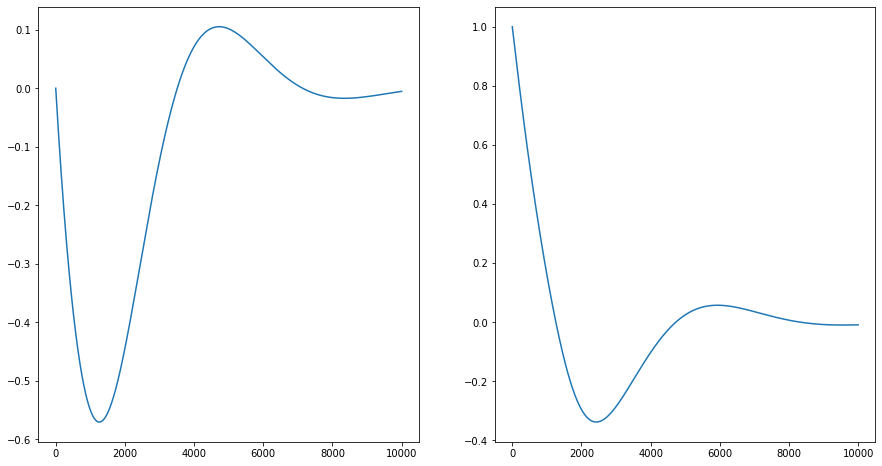

In [4]:
# Generate measurement data
dt = .001

t_train = np.arange(0, 10, dt)
x0_train = [0, 1]
t_train_span = (t_train[0], t_train[-1])
dim = 2
multiple = True

def van_der_pol(t, x, p=[1]):
    return [-x[1],  x[0] - p[0] * (1 - x[0] ** 2) * x[1]]
    
if multiple:
    n_trajectories = 20
    x_train_multi = []
    x0s = np.random.rand(n_trajectories, dim)
    for i in range(n_trajectories):
        x_train_temp = solve_ivp(fun = van_der_pol, t_span=t_train_span, 
                                    y0 = x0s[i], t_eval=t_train, **integrator_keywords).y.T
        x_train_multi.append(x_train_temp)
    print('done with ivp')
x_train = solve_ivp(fun = van_der_pol, t_span = t_train_span, y0 = x0_train, t_eval=t_train, **integrator_keywords).y.T
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(x_train[:,0])
plt.subplot(122)
plt.plot(x_train[:,1])

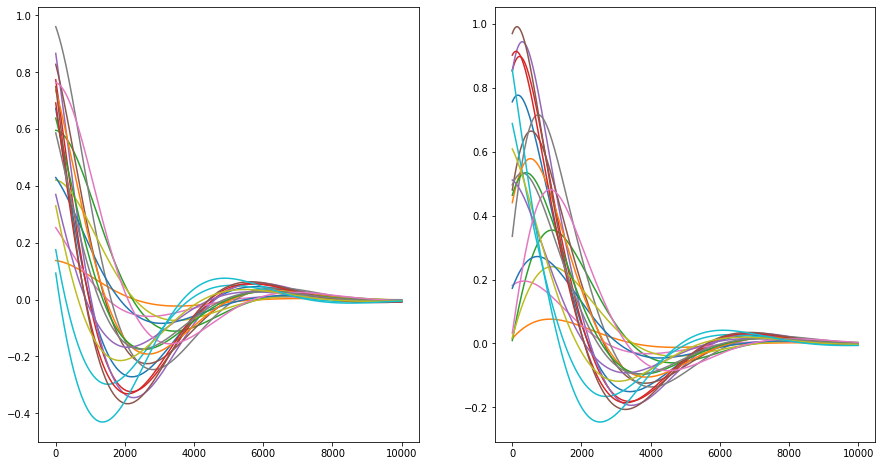

In [5]:
plt.figure(figsize=(15,8))
for i in x_train_multi:
    plt.subplot(121)
    plt.plot(i[:,0])
    plt.subplot(122)
    plt.plot(i[:,1])

In [9]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
# choose a number of time steps
n_steps = 1
# split into samples
X, y = split_sequence(x_train[:,0], n_steps)
print(X.shape, y.shape)

(9999, 1) (9999,)


In [10]:
# X = x_train[:,0][0]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #, random_state=100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7999, 1) (2000, 1) (7999,) (2000,)


In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, activation='relu', input_dim=n_steps))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

2022-08-06 09:38:00.924443: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
history = model.fit(X_train,y_train,validation_data= (X_test, y_test), epochs=20, verbose=1)

Epoch 1/20
250/250 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 3.6371e-09
Epoch 2/20
250/250 [==============================] - 0s 1ms/step - loss: 1.1996e-07 - val_loss: 4.1458e-09
Epoch 3/20
250/250 [==============================] - 0s 1ms/step - loss: 1.0417e-07 - val_loss: 5.8054e-09
Epoch 4/20
250/250 [==============================] - 0s 1ms/step - loss: 9.6709e-08 - val_loss: 1.3580e-09
Epoch 5/20
250/250 [==============================] - 0s 1ms/step - loss: 1.1588e-07 - val_loss: 1.4810e-08
Epoch 6/20
250/250 [==============================] - 0s 1ms/step - loss: 1.0934e-07 - val_loss: 1.4616e-08
Epoch 7/20
250/250 [==============================] - 0s 1ms/step - loss: 1.2162e-07 - val_loss: 3.8675e-08
Epoch 8/20
250/250 [==============================] - 0s 1ms/step - loss: 1.3240e-07 - val_loss: 5.4230e-09
Epoch 9/20
250/250 [==============================] - 0s 1ms/step - loss: 2.0396e-07 - val_loss: 7.7591e-08
Epoch 10/20
250/250 [===========

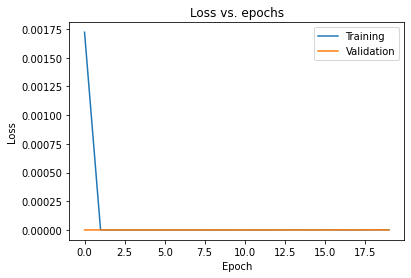

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

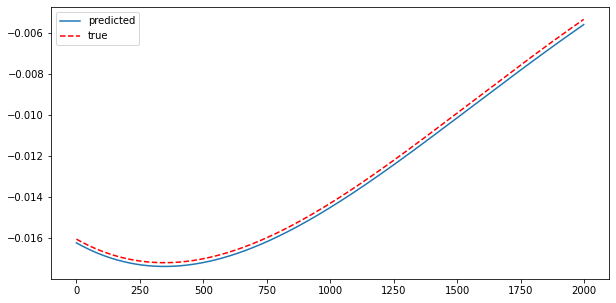

In [15]:
yhat= model.predict(X_test)
plt.figure(figsize=(10,5))
plt.plot(yhat, label = 'predicted')
plt.plot(y_test, 'r--', label = 'true')
plt.legend()

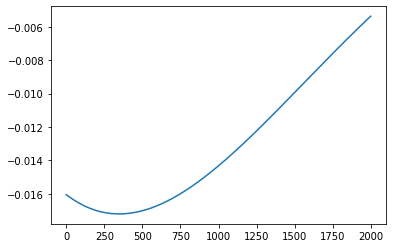

In [16]:
plt.plot(X_test)

In [18]:
x_train.shape

(10000, 2)

In [21]:
# Generate measurement data
dt = .01

t_train = np.arange(0, 10, dt)
x0_train = [0, 1]
t_train_span = (t_train[0], t_train[-1])
dim = 2
multiple = True

def van_der_pol(t, x, p=[1]):
    return [-x[1],  x[0] - p[0] * (1 - x[0] ** 2) * x[1]]

# (1000,2)
x_train = solve_ivp(fun = van_der_pol, 
            t_span = t_train_span, y0 = x0_train, t_eval=t_train,
             **integrator_keywords).y.T


In [22]:
x_train.shape

(1000, 2)

In [25]:
y_true = van_der_pol(np.random.normal(), [2,1])
y_true

[-1, 5]

In [42]:
def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return np.array(y).T

h = 0.1
x = np.random.rand(5,2)
y_true = vf(x)
forward_diff = np.diff(y)/h
x_diff = x[:-1:] 


array([[-0.25469163, -0.19828901],
       [-0.112295  ,  0.56407621],
       [-0.85448551,  0.96081666],
       [-0.33861196,  0.28186563],
       [-0.32308185,  0.49389509]])

In [32]:
x.shape

(5, 2)

In [43]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential([
    Dense(100, activation = 'relu', input_shape = (2,)),
    Dense(256, activation='relu'),
    Dense(1)
])

In [1]:
import pydaddy


| Mx range                       : (-0.801, 0.392)|
| Mx mean                        :     -0.103     |
| My range                       : (-0.599, 1.149)|
| My mean                        :      0.004     |
| |M| range                      : (0.005, 1.158) |
| |M| mean                       :      0.283     |
| Autocorr time (Mx, My, |M^2|)  :  (87, 48, 84)  |
| (Dt, dt)                       :     (1, 1)     |



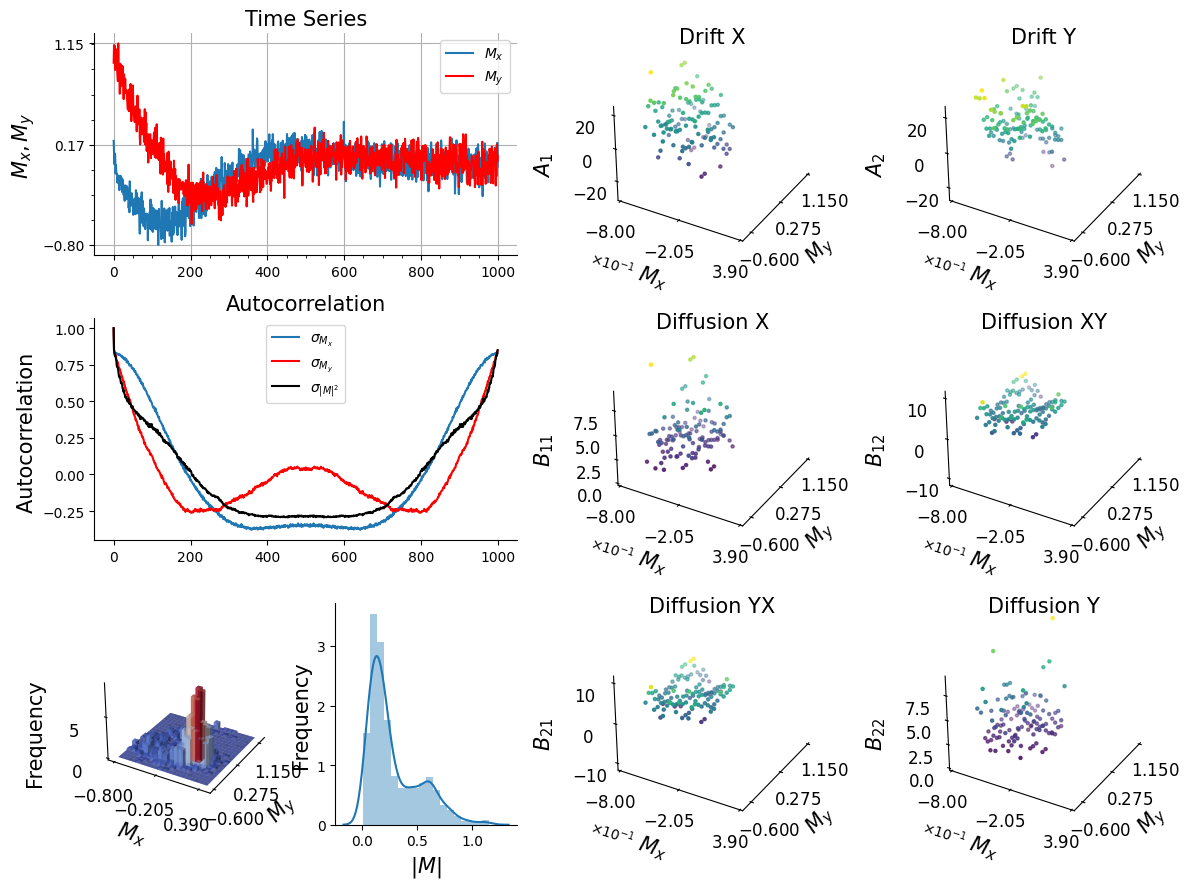

In [7]:
# Generate measurement data
dt = .01

t_train = np.arange(0, 10, dt)
x0_train = [0, 1]
t_train_span = (t_train[0], t_train[-1])
dim = 2
multiple = True

def van_der_pol(t, x, p=[1]):
    return [-x[1],  x[0] - p[0] * (1 - x[0] ** 2) * x[1]]

# (1000,2)
x_train = solve_ivp(fun = van_der_pol, 
            t_span = t_train_span, y0 = x0_train, t_eval=t_train,
             **integrator_keywords).y.T

x_train = x_train + np.random.normal(0 ,0.1, (x_train.shape[0], x_train.shape[1]))

ddsde = pydaddy.Characterize([x_train[:,0], x_train[:,1]], t=t_train, bins =20)

In [73]:
A1 = ddsde.fit('A1', order=3, tune=True)
A2 = ddsde.fit('A2', order=3, tune=True)
B11 = ddsde.fit('B11', order=3, tune=True)
B22 = ddsde.fit('B22', order=3, tune=True)
B21 = ddsde.fit('B21', order=3, tune=True)
for i in [A1, A2, B11, B22, B21]:
    print(i)
    print('--'*30)

(-0.000 ± 0.000) + (-0.005 ± 0.000)x + (0.000 ± 0.000)x^2 + (-0.000 ± 0.000)x^3 + (-0.995 ± 0.000)y + (-0.000 ± 0.000)xy + (-0.005 ± 0.000)x^2y + (0.000 ± 0.000)y^2 + (0.000 ± 0.000)xy^2 + (-0.000 ± 0.000)y^3
------------------------------------------------------------
(0.995 ± 0.001)x + (-0.999 ± 0.001)y + (0.991 ± 0.016)x^2y
------------------------------------------------------------
(-0.000 ± 0.000) + (-0.000 ± 0.000)x + (0.000 ± 0.000)x^2 + (0.000 ± 0.000)x^3 + (0.000 ± 0.000)y + (0.000 ± 0.000)xy + (-0.000 ± 0.000)x^2y + (0.010 ± 0.000)y^2 + (0.000 ± 0.000)xy^2 + (-0.000 ± 0.000)y^3
------------------------------------------------------------
(0.007 ± 0.001)x^2 + (-0.006 ± 0.002)x^3 + (-0.021 ± 0.001)xy + (-0.014 ± 0.002)x^2y + (0.010 ± 0.000)y^2 + (0.004 ± 0.002)xy^2
------------------------------------------------------------
(0.019 ± 0.059)x^2y + (-0.040 ± 0.054)xy^2
------------------------------------------------------------


| Mx range                       : (-0.57, 0.105) |
| Mx mean                        :      -0.1      |
| My range                       :  (-0.338, 1.0) |
| My mean                        :      0.001     |
| |M| range                      :   (0.01, 1.0)  |
| |M| mean                       :      0.222     |
| Autocorr time (Mx, My, |M^2|)  :  (87, 50, 83)  |
| (Dt, dt)                       :     (1, 1)     |

Drift (A1): (-0.000 ± 0.000) + (-0.005 ± 0.000)x + (0.000 ± 0.000)x^2 + (-0.000 ± 0.000)x^3 + (-0.995 ± 0.000)y + (-0.000 ± 0.000)xy + (-0.005 ± 0.000)x^2y + (0.000 ± 0.000)y^2 + (0.000 ± 0.000)xy^2 + (-0.000 ± 0.000)y^3
Drift (A2): (0.995 ± 0.001)x + (-0.999 ± 0.001)y + (0.991 ± 0.016)x^2y
Diffusion (B11): (-0.000 ± 0.000) + (-0.000 ± 0.000)x + (0.000 ± 0.000)x^2 + (0.000 ± 0.000)x^3 + (0.000 ± 0.000)y + (0.000 ± 0.000)xy + (-0.000 ± 0.000)x^2y + (0.010 ± 0.000)y^2 + (0.000 ± 0.000)xy^2 + (-0.000 ± 0.000)y^3
Diffusion (B22): (0.007 ± 0.001)x^2 + (-0.006 ± 0.002)x^3 + (-0.021 

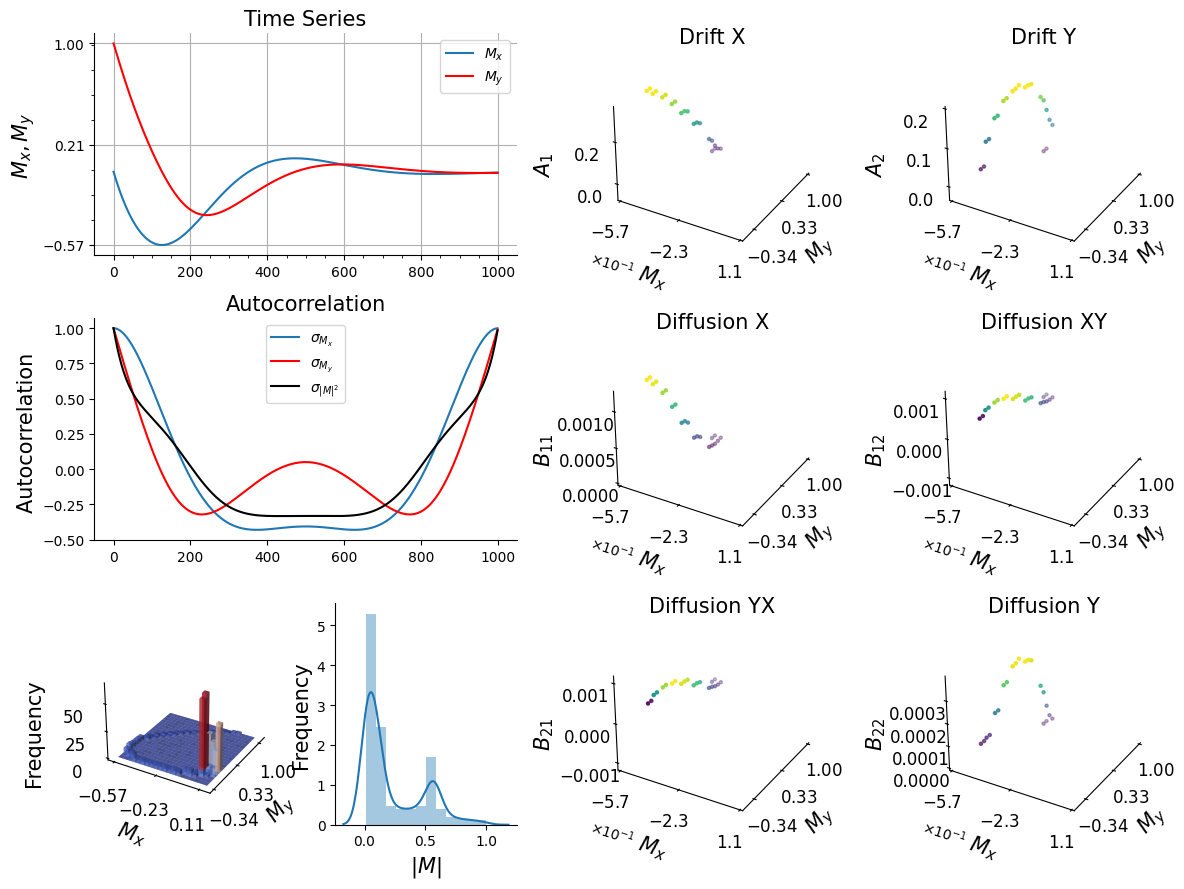

In [74]:
ddsde.summary()

Noise statistics:
Mean: (-0.0000, -0.0077)
Correlation matrix:
    +1.0000    -0.9435
    -0.9435    +1.0000

Noise autocorrelation time:
    eta_x: 402056.924 timesteps (4020.569s)    eta_y: 48.215 timesteps (0.482s)


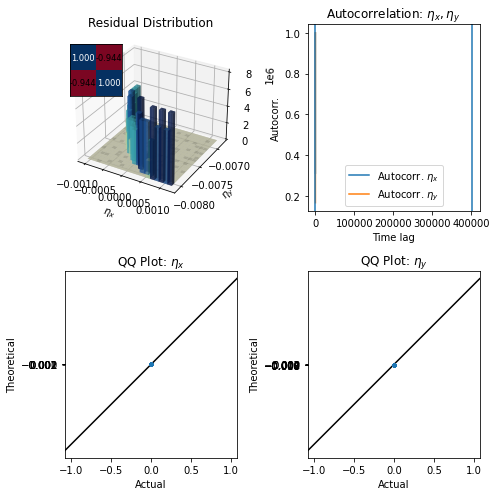

In [75]:
ddsde.noise_diagnostics()

In [76]:
ddsde.fit_diagnostics()


Drift:
 A1 = (-0.000 ± 0.000) + (-0.005 ± 0.000)x + (0.000 ± 0.000)x^2 + (-0.000 ± 0.000)x^3 + (-0.995 ± 0.000)y + (-0.000 ± 0.000)xy + (-0.005 ± 0.000)x^2y + (0.000 ± 0.000)y^2 + (0.000 ± 0.000)xy^2 + (-0.000 ± 0.000)y^3
    Adjusted R-squared : -16.0299
    Adjusted R-squared (without outliers) : -16.0299

Drift:
 A2 = (0.995 ± 0.001)x + (-0.999 ± 0.001)y + (0.991 ± 0.016)x^2y
    Adjusted R-squared : -138.8083
    Adjusted R-squared (without outliers) : -140.2477

Diffusion:
 B11 = (-0.000 ± 0.000) + (-0.000 ± 0.000)x + (0.000 ± 0.000)x^2 + (0.000 ± 0.000)x^3 + (0.000 ± 0.000)y + (0.000 ± 0.000)xy + (-0.000 ± 0.000)x^2y + (0.010 ± 0.000)y^2 + (0.000 ± 0.000)xy^2 + (-0.000 ± 0.000)y^3
    Adjusted R-squared : -63.8596
    Adjusted R-squared (without outliers) : -61.0333

Diffusion:
 B22 = (0.007 ± 0.001)x^2 + (-0.006 ± 0.002)x^3 + (-0.021 ± 0.001)xy + (-0.014 ± 0.002)x^2y + (0.010 ± 0.000)y^2 + (0.004 ± 0.002)xy^2
    Adjusted R-squared : -2534.6995
    Adjusted R-squared (without o

In [81]:
x_train + np.random.normal(loc = 0.0, scale = 0.1)

array([[0.04482736, 1.04482736],
       [0.03487735, 1.03482785],
       [0.02502734, 1.02483126],
       ...,
       [0.03922566, 0.03612224],
       [0.03931255, 0.03615355],
       [0.03939913, 0.03618541]])

### Again with MLP

In [16]:
# Generate measurement data
dt = .01

t_train = np.arange(0, 10, dt)
x0_train = [0, 1]
t_train_span = (t_train[0], t_train[-1])
dim = 2
multiple = True

def van_der_pol(t, x, p=[1]):
    return [-x[1],  x[0] - p[0] * (1 - x[0] ** 2) * x[1]]

# (1000,2)
x_train = solve_ivp(fun = van_der_pol, 
            t_span = t_train_span, y0 = x0_train, t_eval=t_train,
             **integrator_keywords).y.T

In [31]:
print(x_train.shape, t_train.shape)

(1000, 2) (1000,)


In [29]:
with tf.GradientTape() as tape:
    t = tf.constant(t_train)
    tape.watch(t)
    x_train = solve_ivp(fun = van_der_pol, 
                t_span = t_train_span, y0 = x0_train, t_eval=t,
                **integrator_keywords).y.T
dx1_dt = tape.gradient(tf.constant(x_train[:,0]), t)

In [30]:
print(dx1_dt)

None


In [6]:
x = tf.constant(3.)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = 4 * tf.square(x) - x

dydx = tape.gradient(y,x)
dydx

<tf.Tensor: shape=(), dtype=float32, numpy=23.0>

In [19]:
tf.constant(x_train)

<tf.Tensor: shape=(1000, 2), dtype=float64, numpy=
array([[ 0.        ,  1.        ],
       [-0.00995   ,  0.99000049],
       [-0.01980002,  0.9800039 ],
       ...,
       [-0.0056017 , -0.00870512],
       [-0.0055148 , -0.00867381],
       [-0.00542822, -0.00864195]])>